# Data

There are some data classes in `kgcnn` that can help to store and load graph data. In principle a graph is a collection of the follwing objects in tensor-form:

* `nodes_attributes`: Node features of shape `(N, F)` where N is the number of nodes and F is the node feature dimension.
* `edge_indices`: Connection list of shape `(M, 2)` where M is the number of edges. The indices denote a connection of incoming or receiving node `i` and outgoing or sending node `j` as `(i, j)`.
* `edges_attributes`: Edge features of shape `(M, F)` where M is the number of edges and F is the edge feature dimension.
* `graph_attributes`: Graph state information of shape `(F, )` where F denotes the feature dimension.

These can be stored in form of numpy arrays in a dictionary type container `GraphDict`. Additional train/test assignment, labels, positions/coordinates, forces or momentum, other connection indices or even symbols or IDs can be added to this dictionary. 

For multiple small graphs a list of these dictionaries serves to represent the common case of datasets for supervised learning tasks, for example small molecules or crystal structures.

## Graph Dict

Graphs are represented by a dictionary `GraphDict` of (numpy) arrays which behaves like a python dict. In principle the `GraphDict` can take every key and value pair via item operator `[]`. However, for consitency and class methods, keys must be names and values `np.ndarray` . You can use `set` and `get` to out-cast to numpy arrays or run `validate()`. 

In [1]:
import numpy as np
from kgcnn.data.base import GraphDict
# Single graph.
graph = GraphDict({"edge_indices": np.array([[1, 0], [0, 1]]), "node_label":  np.array([[0], [1]])})
graph.set("graph_labels",  np.array([0]))
graph.set("edge_attributes", np.array([[1.0], [2.0]]));
print({key: value.shape for key, value in graph.items()})
print("Is dict: %s" % isinstance(graph, dict))
print("Graph label", graph["graph_labels"])

{'edge_indices': (2, 2), 'node_label': (2, 1), 'graph_labels': (1,), 'edge_attributes': (2, 1)}
Is dict: True
Graph label [0]


The class `GraphDict` can be converted to for example a strict graph representation of `networkx` which keeps track of node and edge changes.

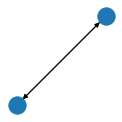

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
nx_graph = graph.to_networkx()
plt.figure(figsize=(1.5,1.5)) 
nx.draw(nx_graph)
plt.show()

Or compiling a dictionary of (tensorial) graph properties from a `networkx` graph.

In [3]:
graph = GraphDict().from_networkx(nx.cubical_graph())
print({key: value.shape for key, value in graph.items()})

{'node_number': (8,), 'edge_indices': (12, 2)}


There are graph pre- and postprocessors in `kgcnn.graph` which take specific properties by name and apply a processing function or transformation. The processing function can for example compute angle indices based on edges or sort edge indices and sort dependent features accordingly. 

> **WARNING**: However, they should be used with caution since they only apply to tensor properties regardless of any underlying graph.


For example `SortEdgeIndices` can sort an "edge_indices" tensor and sort attributed properties such as "edge_attributes" or "edge_labels" or a list of multiple (named) properties accordingly. In the example below a generic search string is also valid. To directly update a `GraphDict` make a preprocessor with `in_place=True` . Note that preprocessors can be serialised and habe a `get_config` method.

In [4]:
from kgcnn.graph.preprocessor import SortEdgeIndices, AddEdgeSelfLoops, SetEdgeWeightsUniform

SortEdgeIndices(edge_indices="edge_indices", edge_attributes="^edge_(?!indices$).*", in_place=True)(graph)

SetEdgeWeightsUniform(edge_indices="edge_indices", value=1.0, in_place=True)(graph)

AddEdgeSelfLoops(
    edge_indices="edge_indices", edge_attributes="^edge_(?!indices$).*", 
    remove_duplicates=True, sort_indices=True, fill_value=0, in_place=True)(graph);

print({key: value.shape for key, value in graph.items()})

{'node_number': (8,), 'edge_indices': (20, 2), 'edge_weights': (20, 1)}


## Graph List

A `MemoryGraphList` should behave identical to a python list but contain only `GraphDict` items.
Here a few examples with some utility methods of the class.

In [5]:
from kgcnn.data.base import MemoryGraphList

# List of graph dicts.
graph_list = MemoryGraphList([
    GraphDict({"edge_indices": [[0, 1], [1, 0]], "graph_label": [0]}), 
    GraphDict({"edge_indices": [[0, 0]], "graph_label": [1]}), 
    GraphDict({"graph_label": [0]})
])

# Remove graphs without certain property
graph_list.clean(["edge_indices"])
print("New length of graph:", len(graph_list))

# Go to every graph dict and take out the requested property. Opposite is set().
print("Labels (list):", graph_list.get("graph_label"))

# Or directly modify list.
for i, x in enumerate(graph_list):
    x.set("graph_number", [i])

print(graph_list)  # Also supports indexing lists.

INFO:kgcnn.data.base:Property 'edge_indices' is not defined for graph '2'.


New length of graph: 2
Labels (list): [array([0]), array([1])]
<MemoryGraphList [{'edge_indices': array([[0, 1],
       [1, 0]]), 'graph_label': array([0]), 'graph_number': array([0])} ...]>


It is also easy to map a a method over the graph dicts in the list. This can be a class method of `GraphDict` or a callable function (or class) or for legacy compatibility a default name of a preprocessor.

In [6]:
graph_list.map_list(method=AddEdgeSelfLoops(edge_indices="edge_indices", in_place=True))

# Note: Former deprecated option is to use a method name that is looked up in the preprocessor class.
# graph_list.map_list(method="add_edge_self_loops")

<MemoryGraphList [{'edge_indices': array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]]), 'graph_label': array([0]), 'graph_number': array([0])} ...]>

Most importantly is to obtain a ragged tensor for direct model input. You can simply pass a list or dict of the config of keras Input layers as shown below:

In [7]:
graph_list.tensor([
    {"name": "edge_indices", "shape": (None, 2), "ragged": True, "dtype": "int64"},
    {"name": "graph_label", "shape": (1, ), "ragged": False}
])

[<tf.RaggedTensor [[[0, 0],
   [0, 1],
   [1, 0],
   [1, 1]], [[0, 0]]]>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[0],
        [1]])>]

## Datasets

The `MemoryGraphDataset` inherits from `MemoryGraphList` but must be initialized with file information on disk that points to a `data_directory` for the dataset. The `data_directory` can have a subdirectory for files and/or single file such as a CSV file. The usual data structure looks like this:

```bash
├── data_directory
    ├── file_directory
    │   ├── *.*
    │   └── ... 
    ├── file_name
    └── dataset_name.kgcnn.pickle
```

In [8]:
from kgcnn.data.base import MemoryGraphDataset
dataset = MemoryGraphDataset(
    data_directory=".",  # Path to file directory or current folder
    dataset_name="Example",
    file_name=None, file_directory=None)

# Modify like a MemoryGraphList
for x in graph_list:
    dataset.append(x)
dataset[0]["node_attributes"] = np.array([[0.9, 3.2], [1.2, 2.4]])
print(dataset)

<MemoryGraphDataset [{'edge_indices': array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]]), 'graph_label': array([0]), 'graph_number': array([0]), 'node_attributes': array([[0.9, 3.2],
       [1.2, 2.4]])} ...]>


You can also change the location on file with `relocate()` . Note that in this case only the file information is changed,
but no files are moved or copied. Save the dataset as pickled python list of python dicts to file:

In [9]:
dataset.save()
dataset.load()

INFO:kgcnn.data.Example:Pickle dataset...
INFO:kgcnn.data.Example:Load pickled dataset...


<MemoryGraphDataset [{'edge_indices': array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]]), 'graph_label': array([0]), 'graph_number': array([0]), 'node_attributes': array([[0.9, 3.2],
       [1.2, 2.4]])} ...]>

### Special Datasets

From `MemoryGraphDataset` there are many subclasses `QMDataset`, `MoleculeNetDataset`, `CrystalDataset`, `VisualGraphDataset` and `GraphTUDataset` which further have functions required for the specific dataset type to convert and process files such as '.txt', '.sdf', '.xyz', '.cif', '.jpg' etc. 
They are located in `kgcnn.data` .
Most subclasses implement `prepare_data()` and `read_in_memory()` with dataset dependent arguments to preprocess and finally load data from different formats.

Then there are fully prepared subclasses in `kgcnn.data.datasets` which download and process common benchmark datasets and can be used as simple as this:

In [10]:
from kgcnn.data.datasets.MUTAGDataset import MUTAGDataset
dataset = MUTAGDataset()  # inherits from GraphTUDataset2020()
dataset[0].keys()

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MUTAG
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting zip file. Stopped.
INFO:kgcnn.data.MUTAG:Reading dataset to memory with name MUTAG
INFO:kgcnn.data.MUTAG:Shift start of graph ID to zero for 'MUTAG' to match python indexing.
INFO:kgcnn.data.MUTAG:Graph index which has unconnected '[]' with '[]' in total '0'.


dict_keys(['node_degree', 'node_labels', 'edge_indices', 'edge_labels', 'graph_labels', 'node_attributes', 'edge_attributes', 'node_symbol', 'node_number', 'graph_size'])

Here are some examples on custom usage of the base classes:

#### MoleculeNetDatasets

> **note**: You can find this page as jupyter notebook in https://github.com/aimat-lab/gcnn_keras/tree/master/notebooks/docs . 